Now that I have full columns, let's make all the summaries in one place

In [3]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json

In [6]:
main_file = "../annos/adotto_TRregions_v1.0.gene.bed.gz"
data = pd.read_csv(main_file, sep='\t', header=None)
HEADER = ['chrom', 'start', 'end', 'ovl_flag', 'up_buff', 'dn_buff', 'hom_span', 'n_filtered', 'n_annos', 'n_subregions',
          'mu_purity', 'pct_annotated', 'interspersed', 'patho', 'codis', 'gene_flag', 'biotype', 'annos']
data.columns = HEADER

def decode_ovl_flag(m_flag):
    flags = ['i', 'n', 'p', 's']
    # turn to a string
    flag_string = " ".join([f for idx, f in enumerate(flags) 
                            if m_flag & (2 ** idx)])
    return flag_string

# How many regions are in our catalog?
data['span'] = data['end'] - data['start']
tot_span = data['span'].sum()
print(len(data), 'regions covering', tot_span, 'bp', round(tot_span / 3.2e9 * 100, 2), '% of genome')

data['span_bin'] = pd.cut(data['span'],
                          bins=[0, 50, 100, 200, 500, 1000, 2500, 10000, 50000], 
                          labels=["[0,50)", "[50,100)", "[100, 200)", "[200, 500)",
                                  "[500, 1000)", "[1000,2500)", "[2500,10k)", 
                                  "[10k,50k)"])

1784804 regions covering 237865075 bp 7.43 % of genome


# Span

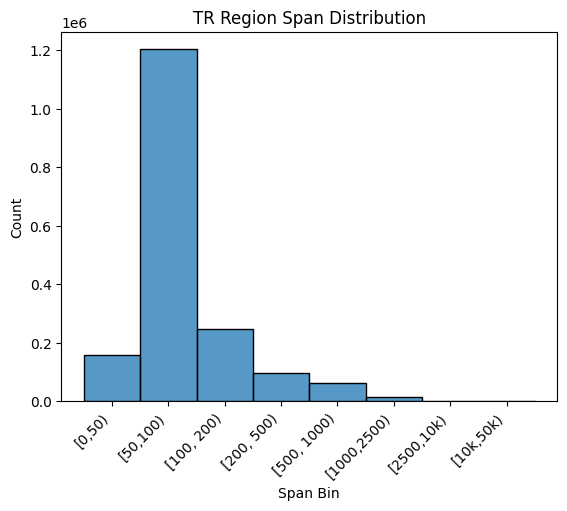

In [82]:
p = sb.histplot(data=data, x='span_bin')
p.set(title="TR Region Span Distribution", xlabel="Span Bin")
hide = plt.xticks(rotation=45, ha='right')

In [83]:
inter = data['interspersed'].value_counts().to_frame().reset_index()
inter.columns = ["Repeat Class", "Count"]
inter['Percent'] = (inter['Count'] / len(data)).round(4)
inter

,Repeat Class,Count,Percent
0,.,1684443,0.9438
1,SINE,89671,0.0502
2,LTR,6576,0.0037
3,Retroposon,2076,0.0012
4,LINE,2003,0.0011
5,DNA,35,0.0000


In [86]:
view = data.melt(value_vars=["n_annos", "n_subregions"])
view.groupby('variable').describe().T.round(2)

variable        n_annos  n_subregions
value count  1784804.00    1784804.00
      mean         1.64          1.46
      std          1.96          1.05
      min          1.00          1.00
      25%          1.00          1.00
      50%          1.00          1.00
      75%          2.00          2.00
      max        296.00        191.00

# Filtering out regions with interspersed repeats

In [85]:
# We're just going to filter these for now
data = data[data['interspersed'] == '.'].copy()
tot_span = data['span'].sum()
print(len(data), 'regions covering', tot_span, 'bp', round(tot_span / 3.2e9 * 100, 2), '% of genome')

1684443 regions covering 173160739 bp 5.41 % of genome


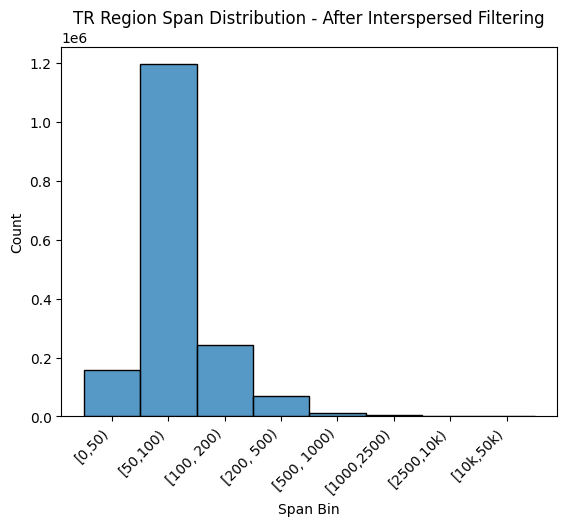

In [9]:
p = sb.histplot(data=data, x='span_bin')
p.set(title="TR Region Span Distribution - After Interspersed Filtering", xlabel="Span Bin")
hide = plt.xticks(rotation=45, ha='right')

# Overlap Flag

In [11]:
ovl_rows = []
cats = ['isolated', 'nested', 'parent', 'staggered_dn', 'staggered_up']
for i in data['ovl_flag']:
    cur_row = []
    for idx, val in enumerate(cats):
        cur_row.append(val if i & (2**idx) else '.')
    ovl_rows.append(cur_row)
ovl_rows = pd.DataFrame(ovl_rows, columns=cats)
ovl_rows['Count'] = 1

In [12]:
ovl_pvt = pd.pivot_table(ovl_rows, values=['Count'], columns=cats, aggfunc=sum).T
ovl_pvt["Count Percent"] = (ovl_pvt["Count"] / len(ovl_rows)).round(4)
ovl_pvt

Count  Count Percent
isolated nested parent staggered_dn staggered_up                        
.        .      parent .            .              284165         0.1687
                       staggered_dn .                1513         0.0009
                                    staggered_up      163         0.0001
         nested parent .            .               36228         0.0215
                       staggered_dn .               10501         0.0062
                                    staggered_up      384         0.0002
isolated .      .      .            .             1160810         0.6891
                       staggered_dn .                5202         0.0031
                                    staggered_up    22926         0.0136
                parent .            .              103958         0.0617
                       staggered_dn .                6429         0.0038
                                    staggered_up    19407         0.0115
         nested parent .            .               13233         0.0079
                       staggered_dn .                6130         0.0036
                                    staggered_up    13394         0.0080

# Let's check out how well our sequences are 'buffered'

[Text(0.5, 0, 'Buffer'), Text(0.5, 1.0, 'Region buffer lengths')]

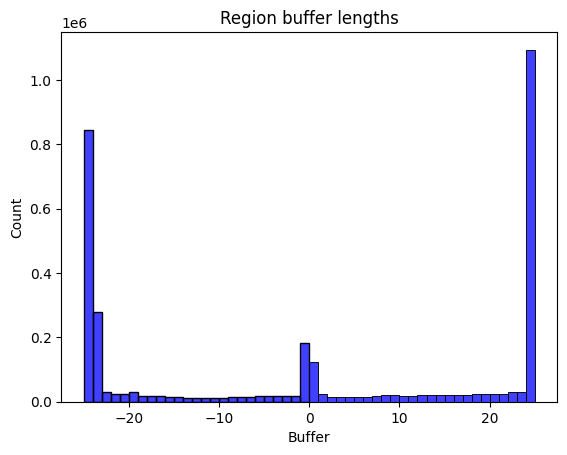

In [13]:
sb.histplot(x=-data['up_buff'], color='blue', binwidth=1)
p = sb.histplot(x=data["dn_buff"], color='blue', binwidth=1)
p.set(xlabel="Buffer", title="Region buffer lengths")

[Text(0.5, 0, 'Buffer'), Text(0.5, 1.0, 'Region buffer ECDF')]

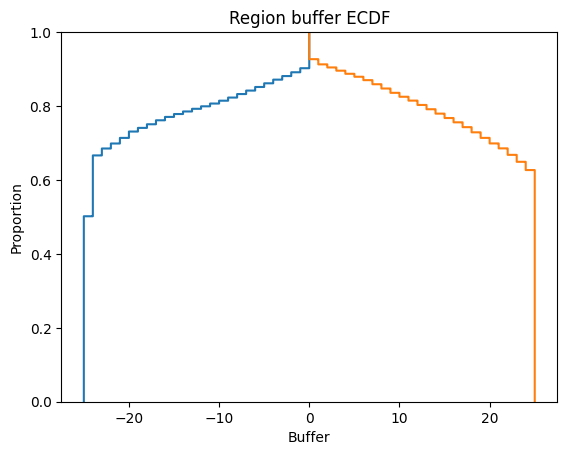

In [14]:
sb.ecdfplot(x=-data['up_buff'])
p = sb.ecdfplot(x=data["dn_buff"], complementary=True)
p.set(xlabel="Buffer", title="Region buffer ECDF")

In [15]:
# 40% have one end with 25bp. Both ends with 25bp is a little worse
rows = []
for i in [5, 10, 20, 25]:
    c = len(data[(data['up_buff'] >= i) & (data['dn_buff'] >= i)])
    rows.append([i, c])
result = pd.DataFrame(rows, columns=["Min Buffer", "Count"])
result['Percent'] = result["Count"] / len(data)
result

,Min Buffer,Count,Percent
0,5,1297178,0.770093
1,10,1156925,0.686829
2,20,892996,0.530143
3,25,543786,0.322828


[Text(0.5, 1.0, 'ECDF of buffer lengths by overlap flag'),
 Text(0.5, 0, 'Buffer')]

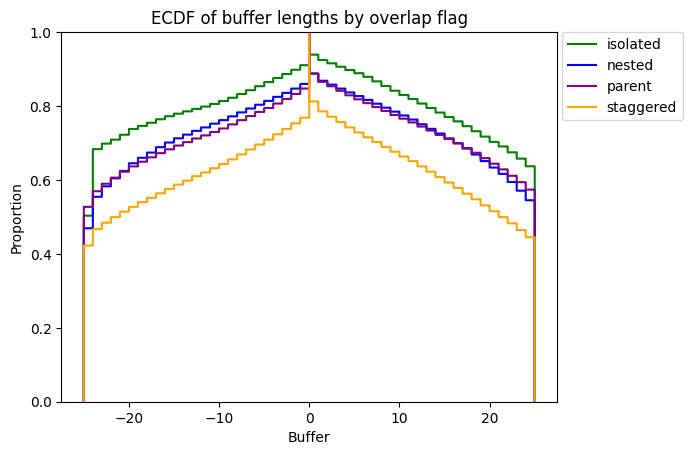

In [16]:
for name, color, flag in [('isolated', 'green', 1), ('nested', 'blue', 4),
                         ('parent', 'purple', 2), ('staggered', 'orange', 8+16)]:
    view = data[(data['ovl_flag'] & (flag)) != 0]
    p = sb.ecdfplot(x=-view["up_buff"], color=color, label=name)
    p = sb.ecdfplot(x=view["dn_buff"], color=color, complementary=True)

plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
p.set(title="ECDF of buffer lengths by overlap flag", xlabel="Buffer")

[Text(0.5, 1.0, 'Buffer by overlap flag'), Text(0.5, 0, 'Buffer')]

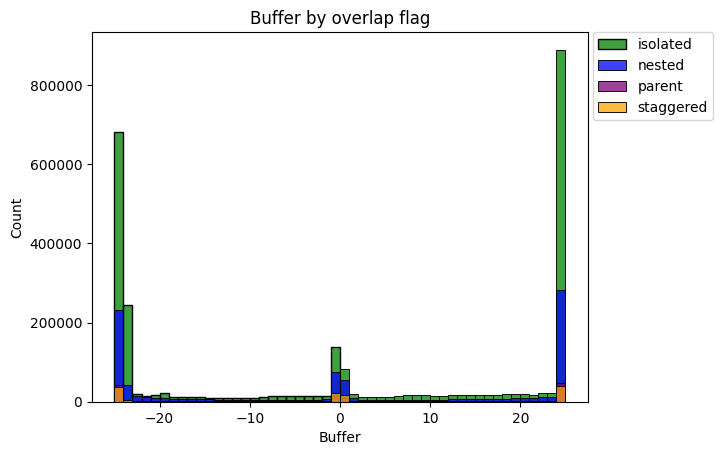

In [17]:
for name, color, flag in [('isolated', 'green', 1), ('nested', 'blue', 4),
                         ('parent', 'purple', 2), ('staggered', 'orange', 8+16)]:
    view = data[(data['ovl_flag'] & flag) != 0]
    p = sb.histplot(x=-view["up_buff"], color=color, label=name, binwidth=1, multiple='stack')
    p = sb.histplot(x=view["dn_buff"], color=color, binwidth=1, multiple='stack')

plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
p.set(title="Buffer by overlap flag", xlabel="Buffer")

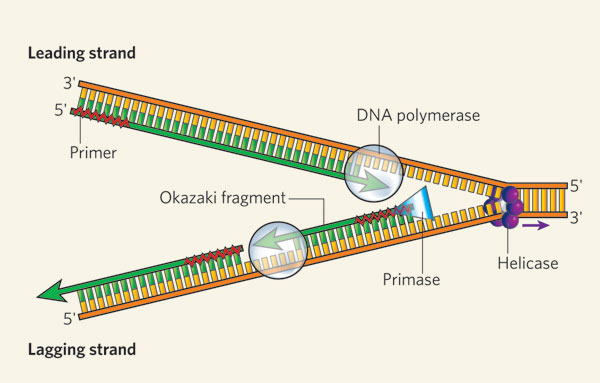

In [18]:
ret = []
for pos, row in data.iterrows():
    j = json.loads(row['annos'])
    max_span = 0
    ans = None
    for i in j:
        span = i['end'] - i['start']
        if span > max_span:
            max_span = span
            ans = i
    ret.append(((ans['ovl_flag'] & 8) != 0, (ans['ovl_flag'] & 16) != 0))
max_span_stagger = pd.DataFrame(ret, columns=['down_stagger', "up_stagger"])

In [19]:
max_span_stagger.groupby(['down_stagger', 'up_stagger']).size().unstack()

up_stagger,False,True
down_stagger,,
False,1629873,26256
True,25861,2453


# Homopolymers

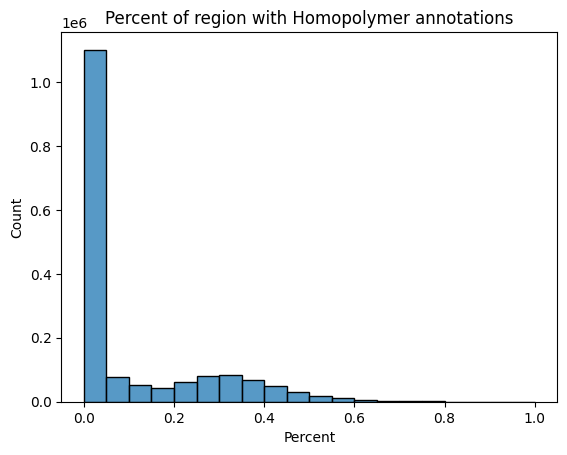

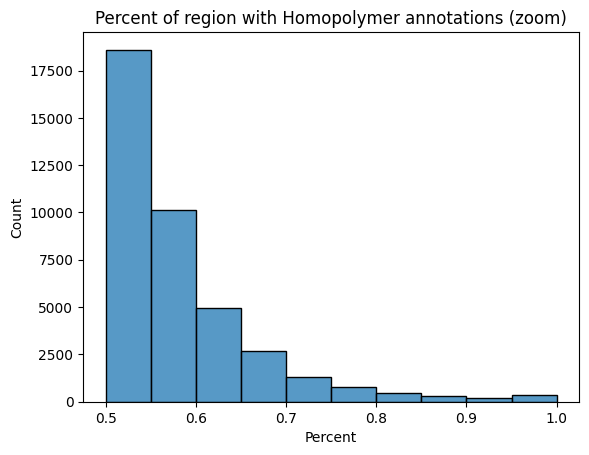

In [96]:
data['hom_pct'] = data['hom_span'] / data['span']
p = sb.histplot(data=data, x="hom_pct", binwidth=0.05)
p.set(title="Percent of region with Homopolymer annotations", xlabel="Percent")
plt.show()
p = sb.histplot(data=data[data['hom_pct'] >= 0.5], x="hom_pct", binwidth=0.05)
hide = p.set(title="Percent of region with Homopolymer annotations (zoom)", xlabel="Percent")

In [97]:
no_good_hompol = (data['hom_pct'] >= 0.50).sum()
print(no_good_hompol, no_good_hompol / len(data))

39761 0.023604835545043674


# Non-buffer sequence annotated

In [98]:
(data['hom_pct'] < 0.50).sum()

1644682

[Text(0.5, 1.0, "Percent of region's non-buffer covered by annotations")]

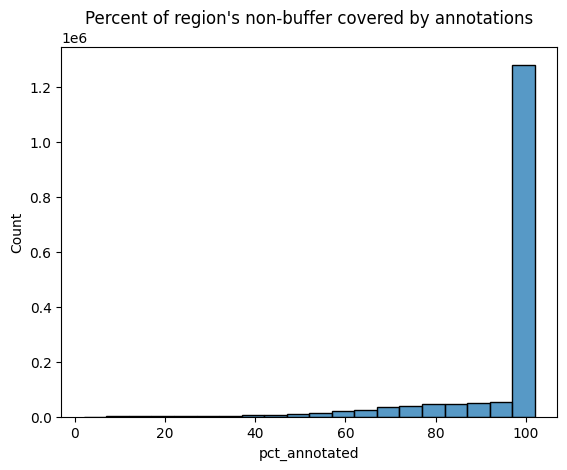

In [99]:
p = sb.histplot(data=data[data['hom_pct'] < 0.50], x="pct_annotated", binwidth=5)
p.set(title="Percent of region's non-buffer covered by annotations")

In [102]:
view = data[(data['interspersed'] == '.') & (data['hom_pct'] < 0.50)]
view.shape

(1644682, 21)

In [103]:
view[(view['pct_annotated'] < 50)].shape

(30627, 21)

[Text(0.5, 1.0, 'Mean Region Purity Distribution')]

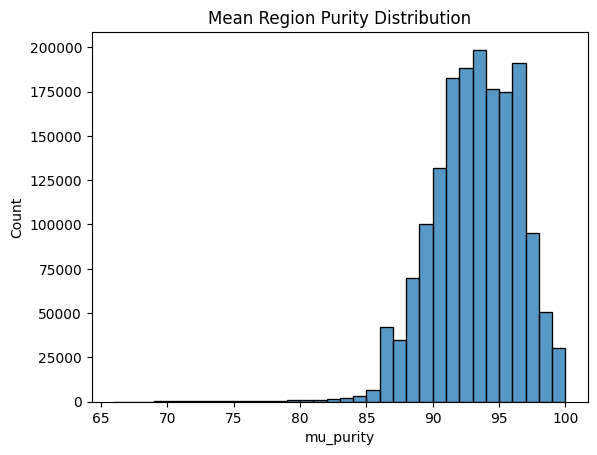

In [25]:
p = sb.histplot(data=data, x="mu_purity", binwidth=1)
p.set(title="Mean Region Purity Distribution")

# Patho/Codis

Make sure that all the patho and codis are present.

In [19]:
# Go back to the originals
unfilt = pd.read_csv(main_file, sep='\t', header=None)
unfilt.columns = HEADER
print('patho_total =', 56)
print('unfilt', unfilt[unfilt['patho'] != '.'].shape)
print('filt', data[data['patho'] != '.'].shape)

patho_total = 56
unfilt (56, 18)
filt (56, 20)


In [20]:
print('codis_total =', 53)
print('unfilt', unfilt[unfilt['codis'] != '.'].shape)
print('filt', data[data['codis'] != '.'].shape)

codis_total = 53
unfilt (51, 18)
filt (51, 20)


In [4]:
# crap
patho = pd.read_csv("../../pathogenic/pathogenic_repeats.hg38.bed", sep='\t', header=None)
patho.columns = ['chrom', 'start', 'end', 'gene']
patho['gene'] = patho['gene'].apply(lambda x: x.split(';')[0][len("ID="):])

codis = pd.read_csv("../../codis/hg38_codis.bed", sep='\t', header=None)
codis.columns = ['chrom', 'start', 'end', 'name']

In [22]:
codis[~codis['name'].isin(data['codis'])]

,chrom,start,end,name
21,chrY,12500448,12500495,DYS389I
22,chrY,12500448,12500611,DYS389II
33,chrY,18888956,18888995,DYS460
34,chrY,18888804,18888851,DYS461


In [23]:
data[data['codis'] == 'DYS461,DYS460'].T

,1781893
chrom,chrY
start,18888771
end,18889019
ovl_flag,1
up_buff,23
dn_buff,25
hom_span,0
n_filtered,0
n_annos,1
n_subregions,1


So the codis aren't actually missing. They're just overlapping themselves in two chrY loci.

In [24]:
# We're missing 3 pathogenic TRs from the filter
mis_patho = patho[~patho['gene'].isin(data['patho'])]
mis_patho

,chrom,start,end,gene


In [25]:
j = unfilt[unfilt['patho'].isin(mis_patho['gene'])]
j

,chrom,start,end,ovl_flag,up_buff,dn_buff,hom_span,n_filtered,n_annos,n_subregions,mu_purity,pct_annotated,interspersed,patho,codis,gene_flag,biotype,annos


In [26]:
j['hom_span'] / (j['end'] - j['start'])

Series([], dtype: float64)

Another consequence of the intrahelical nature of SSM is the expectation that
SSM should have an appreciable bias toward the duplication of shorter repeat units;
if the initial event involves local melting and reannealing of the duplex, then a shorter
slippage should be more likely than a longer one, since it distorts the normal configuration of the molecule less. Observed rates of SSM in vitro are consistent with this
expectation; Wells et al. ( 1967b) found that elongation rates decreased considerably
when the length of the repeat unit was increased from 2 to 4. 

# Genes

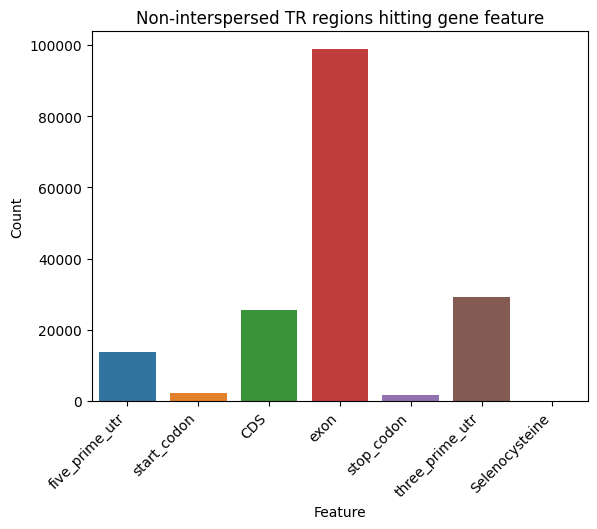

In [7]:
keep = (data['interspersed'] == '.') & (data['biotype'] != '.')

feature_flags = {
#        "transcript": 1,
         "gene": 1,
         "five_prime_utr": 2,
         "start_codon": 4,
         "CDS": 8,
         "exon": 16,
         "stop_codon": 32,
         "three_prime_utr": 64,
         "Selenocysteine": 128,
        }

m_order = list(feature_flags.keys())
m_order.insert(0, 'intergenic')
m_order = m_order[2:]

n_rows = []
for name, flag in feature_flags.items():
    n_rows.append([name, ((data[keep]['gene_flag'] & flag) != 0).sum()])
    
n_rows.append(['intron_only', (data[keep]['gene_flag'] == 1).sum()])
#m_order.append('intron_only')

n_rows = pd.DataFrame(n_rows, columns=['Feature', 'Count'])
n_rows["Percent"] = n_rows["Count"] / len(data[keep]) * 100
p = sb.barplot(data=n_rows, x="Feature", y="Count", order=m_order)
p.set(title="Non-interspersed TR regions hitting gene feature")
hide = plt.xticks(rotation=45, ha='right')


In [8]:
print(len(data[keep]), len(data[keep]) / len(data[data['interspersed'] == '.']))
n_rows

1045093 0.6204383288719179


,Feature,Count,Percent
0,gene,1045093,100.000000
1,five_prime_utr,13877,1.327824
2,start_codon,2296,0.219693
3,CDS,25465,2.436625
4,exon,98842,9.457723
5,stop_codon,1748,0.167258
6,three_prime_utr,29347,2.808075
7,Selenocysteine,1,0.000096
8,intron_only,946251,90.542277


,Feature,Count,Percent
0,gene,55,98.214286
1,five_prime_utr,23,41.071429
2,start_codon,12,21.428571
3,CDS,28,50.000000
4,exon,43,76.785714
5,stop_codon,2,3.571429
6,three_prime_utr,3,5.357143
7,Selenocysteine,0,0.000000
8,intron_only,12,21.428571


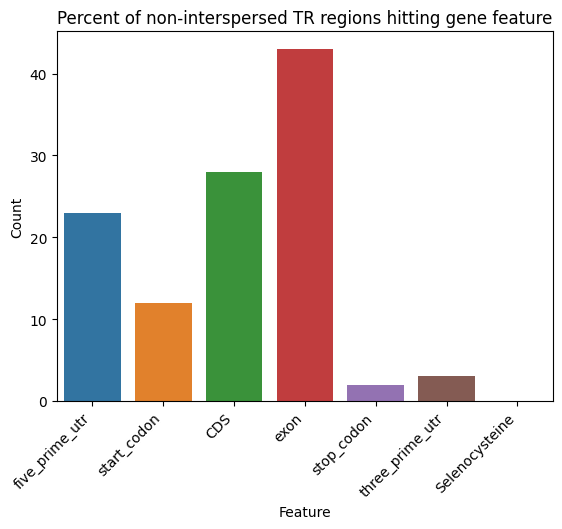

In [14]:
# Patho only
keep = data['patho'] != '.'

feature_flags = {
#         "transcript": 1,
         "gene": 1,
         "five_prime_utr": 2,
         "start_codon": 4,
         "CDS": 8,
         "exon": 16,
         "stop_codon": 32,
         "three_prime_utr": 64,
         "Selenocysteine": 128,
        }

m_order = list(feature_flags.keys())
m_order.insert(0, 'intergenic')
m_order = m_order[2:]

n_rows = []
for name, flag in feature_flags.items():
    n_rows.append([name, ((data[keep]['gene_flag'] & flag) != 0).sum()])
    
n_rows.append(['intron_only', (data[keep]['gene_flag'] == 1).sum()])
#m_order.append('intron_only')

n_rows = pd.DataFrame(n_rows, columns=['Feature', 'Count'])
n_rows["Percent"] = n_rows["Count"] / len(data[keep]) * 100
p = sb.barplot(data=n_rows, x="Feature", y="Count", order=m_order)
p.set(title="Percent of non-interspersed TR regions hitting gene feature")
hide = plt.xticks(rotation=45, ha='right')
n_rows

In [15]:
data[(data['patho'] != '.') & (data['gene_flag'] == 0)]

,chrom,start,end,ovl_flag,up_buff,dn_buff,hom_span,n_filtered,n_annos,n_subregions,mu_purity,pct_annotated,interspersed,patho,codis,gene_flag,biotype,annos,span,span_bin
976167,chr21,43776412,43776503,4,25,25,0,2,1,1,92,100,.,CSTB,.,0,.,"[{""chrom"": ""chr21"", ""start"": 43776437, ""end"": ...",91,"[50,100)"


In [40]:
data[(data['biotype'] != '.') & (data['interspersed'] == '.')]['biotype'].value_counts()[:10]

protein_coding                                       713664
lncRNA                                               238702
protein_coding,lncRNA                                 59899
transcribed_unprocessed_pseudogene                     9365
unprocessed_pseudogene                                 4537
transcribed_processed_pseudogene                       3546
transcribed_unitary_pseudogene                         3044
processed_pseudogene                                   1811
transcribed_unprocessed_pseudogene,lncRNA              1552
protein_coding,transcribed_unprocessed_pseudogene      1081
Name: biotype, dtype: int64

# Annotations removed

In [43]:
tot_anno = unfilt['n_filtered'] + unfilt['n_annos']
tot_anno.sum(), unfilt['n_filtered'].sum() / tot_anno.sum()

(5362688, 0.45273620244176055)

In [44]:
unfilt['n_filtered'].sum()

2427883

In [45]:
unfilt['n_annos'].sum()

2934805

In [46]:
unfilt[['n_annos', 'n_subregions']].describe()

,n_annos,n_subregions
count,1.784804e+06,1.784804e+06
mean,1.644329e+00,1.457342e+00
std,1.963422e+00,1.054524e+00
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,1.000000e+00,1.000000e+00
75%,2.000000e+00,2.000000e+00
max,2.960000e+02,1.910000e+02


In [47]:
# Already interspersed filtered 
keep = data[(data['hom_pct'] < 0.50) & (data['interspersed'] == '.')]

# Let's check motifs of our catalog vs the known pathogenic

In [2]:
patho = pd.read_csv("../../pathogenic/pathogenic_repeats.hg38.bed", sep='\t', header=None)
patho.columns = ['chrom', 'start', 'end', 'info']
def info_split(x):
    ret = []
    for i in x.split(';'):
        ret.append(i.split('=')[1])
    return ret
patho = pd.concat([patho, pd.DataFrame(patho['info'].apply(info_split).to_list(), columns=["ID", "MOTIFS", "STRUC"])], axis=1)

NameError: name 'pd' is not defined

In [28]:
m_patho = unfilt[unfilt['patho'] != '.'].copy()
m_patho.set_index('patho', inplace=True)
patho.set_index('ID', inplace=True)
patho = patho.join(m_patho, rsuffix='_ad')

In [29]:
def roll_compare(a, b):
    """
    See if the motif is a roll of the other
    """
    if len(a) != len(b):
        return False
    if a == b:
        return True
    roll_number = 1
    while roll_number < len(a):
        c_a = a[roll_number:] + a[:roll_number]
        if c_a == b:
            return True
        roll_number += 1
    return False
roll_compare("CCG", "GCC")

True

In [30]:
has_match = []
did_roll = 0
for idx, row in patho.iterrows():
    p_motifs = set(row['MOTIFS'].split(','))
    try:

        m_motifs = set([_['motif'] for _ in json.loads(row['annos'])])
    except Exception as e:
        print(row)
        raise e
    match = len(p_motifs.intersection(m_motifs)) != 0
    if match:
        has_match.append(match)
        continue
    # Work for it
    any_roll = False
    for i in p_motifs:
        for j in m_motifs:
            any_roll = any_roll or roll_compare(i, j)
    has_match.append(any_roll)
    if any_roll:
        did_roll += 1
    
patho['has_match'] = has_match
print(did_roll)

18


In [31]:
# How many have a good motif description:
patho['has_match'].value_counts()

True     41
False    15
Name: has_match, dtype: int64

In [32]:
# However, some of the patho motifs are 'N', so hard to compare
# Maybe I should just manually look at it?
(patho['MOTIFS'].str.count('N') == 0).value_counts()

True     49
False     7
Name: MOTIFS, dtype: int64

In [33]:
# Manually align the 'N' p_motifs
for idx, row in patho[~patho['has_match'] & (patho['MOTIFS'].str.count('N') == 1)].iterrows():
    print(row['MOTIFS'], [_['motif'] for _ in json.loads(row['annos'])])

GCN ['CAGCGGCGG']
GCN ['CCT', 'GGCCGGA', 'AGAGGGAG', 'TCG', 'GGCTAC', 'CGCTCCAG', 'CGGGGGCGC', 'CGCGC', 'GGGCCAGGGCC', 'CGG', 'CGG']
NGC ['GGCATG', 'GCGGCTGCAGCCGCA']
GCN ['CCG', 'TGGGGT', 'GCC', 'CGCTGCCGCTGCG', 'GCCCCCGG']
GCN ['GGCGGCGGCGGCGGCTGC', 'CCGCCCC', 'GCA']
NGC ['GCCCGCCGG', 'GCG', 'GCC', 'GCC', 'GGCGCCAAG', 'GGCCGG', 'GGCGGGATCGCGCCA']
NGC ['GTCTTG', 'GCCCAC', 'GCGGCA']


7 of the 7 non-N ~has_match motifs are okay,

In [34]:
for idx, row in patho[~patho['has_match'] & (patho['MOTIFS'].str.count('N') == 0)].iterrows():
    print(idx + '\t' + row['MOTIFS'] + '\t' + ", ".join([_['motif'] for _ in json.loads(row['annos'])]))

NOTCH2NLC	GGC	CGC
NIPA1	GCG	CCCCCGTCCCG, GCGGCGGCA, GCC
AFF3	GCC	AG, GCCC, CGCCCGCCCCG, CGCGCGCCC, GCCCTGGGGCG
CSTB	CGCGGGGCGGGG	GGGGCGC
ZNF713	CGG	GCGGCGGGCGGCG, CCGCTGTCC
FXN	A,GAA	TACAAAAAAA
ARX	GCG	GCCC, GCT, GCCG, GCGGCC
TMEM185A	GCC	TCC, GCGCCA, GCCGCC


In [35]:
patho['m_motif'] = patho['annos'].apply(lambda x: ", ".join([_['motif'] for _ in json.loads(x)]))
patho[~patho['has_match']][['MOTIFS', "m_motif"]].to_csv("gen.txt", sep='\t')

In [38]:
print(json.dumps(json.loads(patho.loc["HOXA13"]['annos']), indent=4))

[
    {
        "chrom": "chr7",
        "start": 27199639,
        "end": 27199659,
        "period": 9.0,
        "copies": 2.3,
        "score": 63,
        "entropy": 0.99,
        "ovl_flag": 1,
        "motif": "GCCCGCCGG",
        "purity": 100
    },
    {
        "chrom": "chr7",
        "start": 27199679,
        "end": 27199742,
        "period": 3.0,
        "copies": 21.0,
        "score": 92,
        "entropy": 1.42,
        "ovl_flag": 1,
        "motif": "GCG",
        "purity": 91
    },
    {
        "chrom": "chr7",
        "start": 27200002,
        "end": 27200011,
        "period": 3.0,
        "copies": 3.3,
        "score": 30,
        "entropy": 0.97,
        "ovl_flag": 1,
        "motif": "GCC",
        "purity": 90
    },
    {
        "chrom": "chr7",
        "start": 27199826,
        "end": 27199966,
        "period": 3.0,
        "copies": 47.0,
        "score": 112,
        "entropy": 1.52,
        "ovl_flag": 1,
        "motif": "GCC",
        "purity"

# Anno coverage

Our percent of the genome covered is inflated because of the buffer. So a more accurate estimation would be:
span - up_buff - dn_buff. Then separately multiply by the pct_annotated:

In [87]:
n_pct = (data['span'] - data['up_buff'] - data['dn_buff']) * (data["pct_annotated"] / 100)

In [90]:
n_pct.describe().round(2)

count    1684443.00
mean          57.69
std          401.66
min            5.00
25%           18.00
50%           30.03
75%           48.02
max        48878.48
dtype: float64

In [91]:
data['span'].describe().round(2)

count    1684443.00
mean         102.80
std          419.99
min            7.00
25%           61.00
50%           72.00
75%           93.00
max        49889.00
Name: span, dtype: float64

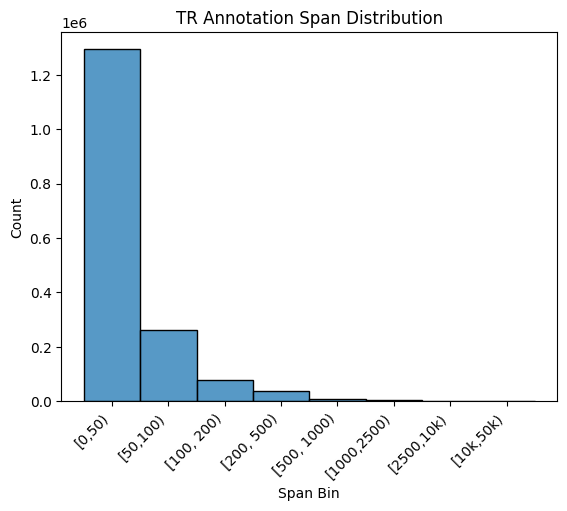

In [93]:
pct_bin = pd.cut(n_pct,
                 bins=[0, 50, 100, 200, 500, 1000, 2500, 10000, 50000], 
                 labels=["[0,50)", "[50,100)", "[100, 200)", "[200, 500)",
                         "[500, 1000)", "[1000,2500)", "[2500,10k)", 
                         "[10k,50k)"])
p = sb.histplot(pct_bin)
p.set(title="TR Annotation Span Distribution", xlabel="Span Bin")
hide = plt.xticks(rotation=45, ha='right')

In [94]:
n_pct.sum(), n_pct.sum() / 3.2e9

(97169962.89999996, 0.030365613406249988)

In [5]:
patho

,chrom,start,end,gene
0,chr1,57367043,57367119,DAB1
1,chr1,146228800,146228822,NOTCH2NLC
2,chr1,149390802,149390841,NOTCH2NL
3,chr10,79826383,79826404,NUTM2B-AS1
4,chr10,93702522,93702547,FRA10AC1
5,chr11,66744821,66744850,C11ORF80
6,chr11,119206289,119206322,CBL
7,chr12,6936716,6936773,ATN1
8,chr12,50505001,50505022,DIP2B
9,chr12,111598949,111599018,ATXN2


In [10]:
gno = pd.read_csv("/Users/english/Downloads/gno.txt", sep='\t')
gno[~gno["ID"].isin(patho["gene"])]

,ID,Reference repeat unit,Region,Inheritance mode,Associated disease(s)
2,ARX_1,NGC,coding: polyalanine,X-linked recessive,"Developmental and epileptic encephalopathy-1, ..."
3,ARX_2,NGC,coding: polyalanine,X-linked recessive,"Developmental and epileptic encephalopathy-1, ..."
10,ATXN8OS,CTG,3'-UTR,Autosomal dominant,Spinocerebellar ataxia 8
19,DMD,TTC,intron,X-linked recessive,Duchenne muscular dystrophy
21,EIF4A3,CCTCGCTGTGCCGCTGCCGA,5'-UTR,Autosomal recessive,Richieri-Costa-Pereira syndrome
27,HOXA13_1,NGC,coding: polyalanine,Autosomal dominant,Hand-foot-genital syndrome
28,HOXA13_2,NGC,coding: polyalanine,Autosomal dominant,Hand-foot-genital syndrome
29,HOXA13_3,NGC,coding: polyalanine,Autosomal dominant,Hand-foot-genital syndrome
42,PRDM12,GCC,coding: polyalanine,Autosomal recessive,Hereditary sensory and autonomic neuropathy ty...
43,PRNP,CCTCATGGTGGTGGCTGGGGGCAG,coding: other,Autosomal dominant,Creutzfeldt-Jakob disease


In [11]:
patho

,chrom,start,end,gene
0,chr1,57367043,57367119,DAB1
1,chr1,146228800,146228822,NOTCH2NLC
2,chr1,149390802,149390841,NOTCH2NL
3,chr10,79826383,79826404,NUTM2B-AS1
4,chr10,93702522,93702547,FRA10AC1
5,chr11,66744821,66744850,C11ORF80
6,chr11,119206289,119206322,CBL
7,chr12,6936716,6936773,ATN1
8,chr12,50505001,50505022,DIP2B
9,chr12,111598949,111599018,ATXN2
